In [24]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

def parse_data(paths):
    result_dict = {}
    dicts = []
    for path in paths:
        with open(path, 'rb') as f:
            dicts.append(pickle.load(f))
    for dict in dicts:
        for key in dict:
            next_entrance = dict[key].reshape([1, -1])
            if key in result_dict:
                result_dict[key] = np.append(result_dict[key], next_entrance, axis=0)
            else:
                result_dict[key] = next_entrance
    return result_dict

def file_crawler(path, substrings, exclude=[]):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            file_path = os.path.join(root, name)
            if all(s in file_path for s in substrings) and not any(e in file_path for e in exclude):
                result.append(file_path)
    print(f'for path: {path}: {len(result)}')
    return result

def plot_experiment_data(timesteps, experiments, names, plot_name, path=None, plot_closest=False):
    # create figure and axis objects
    fig, ax = plt.subplots()

    # find the experiment with the smallest number of timesteps n_timesteps with timestep values p_timesteps
    min_timesteps = min([len(t) for t in timesteps])
    p_timesteps = timesteps[[len(t) for t in timesteps].index(min_timesteps)]
    # for all other experiments, find the n_timesteps timesteps, that are the closest to p_timesteps

    new_experiments = []
    if plot_closest:
        for exp in range(len(experiments)):
            if timesteps[exp][0] != 0:
                experiments[exp] = np.concatenate((np.zeros_like(experiments[exp][:,:1]), experiments[exp]), axis=1)
                timesteps[exp] = np.concatenate((np.zeros_like(timesteps[exp][:1]), timesteps[exp]), axis=0)
            dist_timesteps = (timesteps[exp][None,:] - p_timesteps[:, None])**2
            ind_new_timesteps = np.argmin(dist_timesteps, axis=1)
            new_experiments.append(experiments[exp][:, ind_new_timesteps])
    else:
        new_experiments = experiments
            

    # loop over experiments
    for i, experiment in enumerate(new_experiments):
        # calculate mean and standard deviation of each time step for this experiment
        mean_data = np.mean(experiment, axis=0)
        std_data = 1 / np.sqrt(experiment.shape[0]) * np.std(experiment, axis=0)

        # plot mean data as a line and shade area between ±1 standard deviation
        if plot_closest:
            # plot the experiments at those timesteps
            ax.plot(p_timesteps, mean_data, '-o', markersize=5, label=names[i])
            ax.fill_between(p_timesteps, mean_data-std_data, mean_data+std_data, alpha=0.3)
        else:
            ax.plot(timesteps[i], mean_data, '-o', markersize=5, label=names[i])
            ax.fill_between(timesteps[i], mean_data-std_data, mean_data+std_data, alpha=0.3)

    # add labels, title, and legend to the plot
    ax.set_xlabel('Number Sampled Trajectories')
    ax.set_ylabel('Success Rate')
    ax.set_title(plot_name)
    ax.legend()
    if path is not None:
        # create directory if it doesn't exist
        os.makedirs(path, exist_ok=True)
        # save the plot
        plt.savefig(os.path.join(path, plot_name + '.png'))

def make_plot(paths, includes, excludes, names, plot_name, save_path = None, plot_closest=False):
    abs_file_path_list = []
    
    for i in range(len(paths)):
        abs_file_path_list.append(file_crawler(path=paths[i], substrings=includes[i], exclude=excludes[i]))
    dicts = []
    
    for result in abs_file_path_list:
        dicts.append(parse_data(paths=result))

    plot_experiment_data(
        timesteps=[result_dict['step'][0] for result_dict in dicts], 
        experiments=[result_dict['success_rate'] for result_dict in dicts],
        names=names,
        plot_name=plot_name,
        path=save_path,
        plot_closest=plot_closest
        )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-26: 1


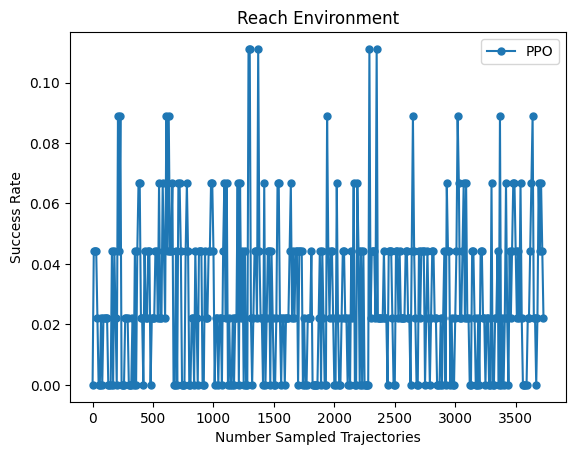

In [45]:
ac_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-26'

include_ac = ['reach new plan in inf lin critic eps: 20000 opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'statsoptimized']
exlude_ac = []
make_plot(
    paths=[ac_path], 
    includes=[include_ac], 
    excludes=[exlude_ac],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25: 1


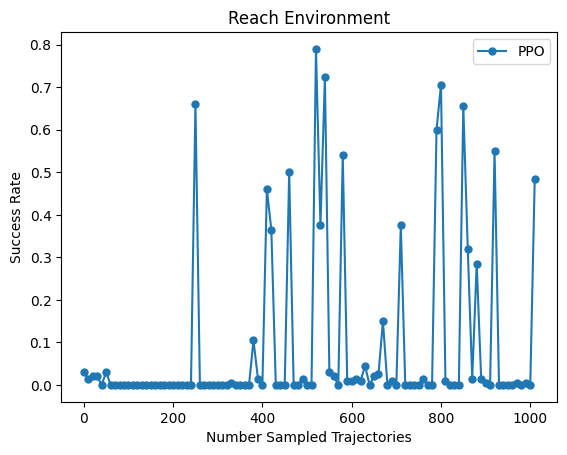

In [13]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['TQC_drawerclose_lr_1e-05_demonstrations_0_n_samples_1000_id_0', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /data/bing/hendrik/AC_var_2023-03-25/: 1
for path: /data/bing/hendrik/AC_var_2023-03-25/: 1


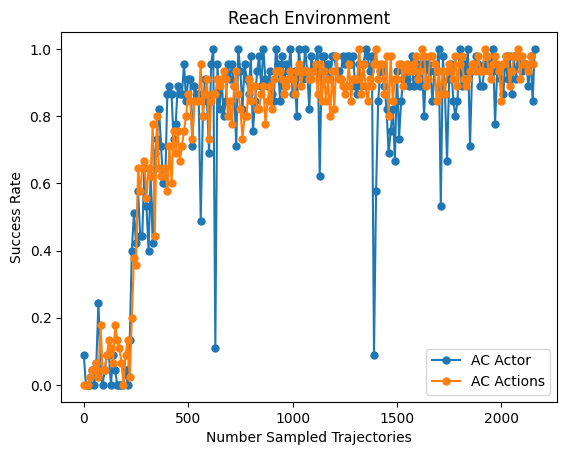

In [49]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-25/'
AC_path_actions = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22/'

include_Ac = ['reach new plan in inf lin critic eps: 5000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'statsoptimized']
exclude_AC = []

include_Ac_non = ['reach new plan in inf lin critic eps: 5000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000 run id: 0', 'stats']
exclude_AC_non = ['optimized']

include_Ac_actions = ['reach opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'statsoptimized']
exclude_AC_actions = ['id: 1']

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_Ac, include_Ac_non], 
    excludes=[exclude_AC, exclude_AC_non],
    names=['AC Actor', 'AC Actions'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22/: 1


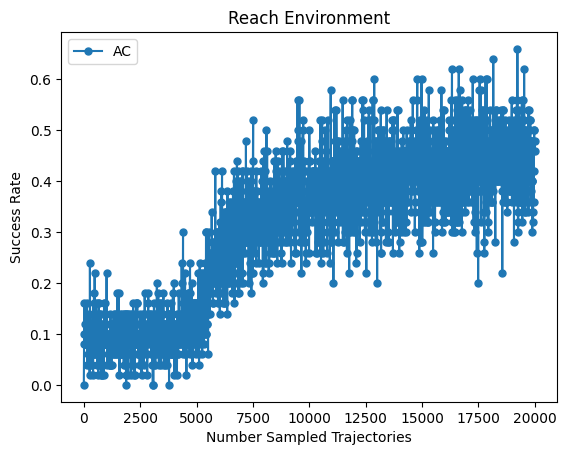

In [39]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22/'

include_Ac = ['reach opt mode: actions demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'statsoptimized']
exclude_AC = ['id: 1']

make_plot(
    paths=[AC_path], 
    includes=[include_Ac], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25: 3


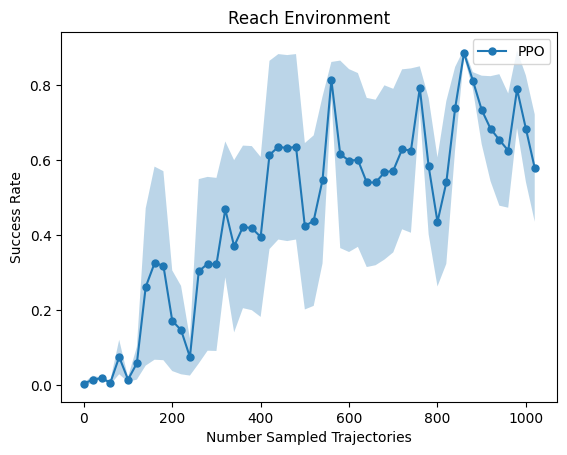

In [15]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['PPO_drawerclose_lr_1e-05_demonstrations_0_n_samples_1000', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25: 3


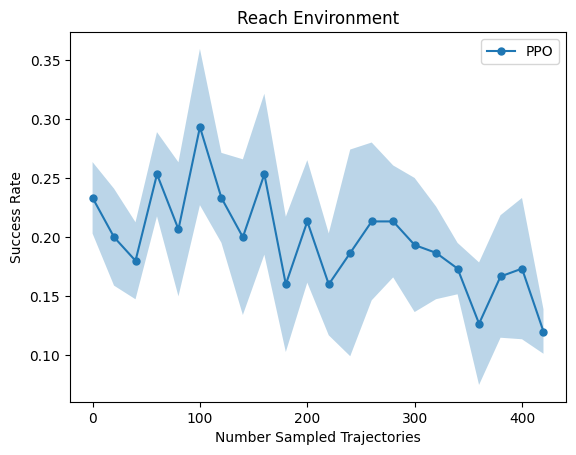

In [19]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['RPPO_reach_lr_1e-06_demonstrations_4', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25: 3


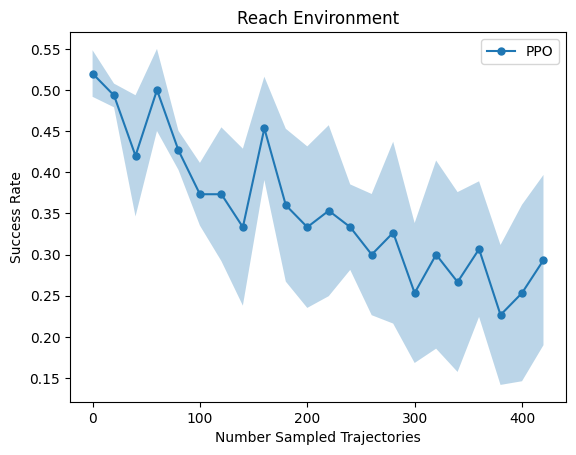

In [22]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'

include_PPO = ['TQC_GAIL_windowopen_lr_1e-07_demonstrations_4', 'learner']
exclude_PPO = []

make_plot(
    paths=[bl_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )


for path: /data/bing/hendrik/AC_var_2023-03-24/: 3


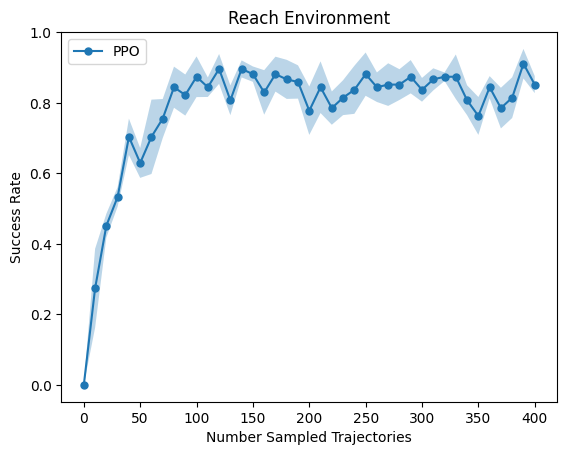

In [23]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-24/'

include_AC = ['windowopenincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 'statsoptimized']
exclude = []

make_plot(
    paths=[AC_path], 
    includes=[include_AC], 
    excludes=[exclude],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /data/bing/hendrik/AC_var_2023-03-24/: 3
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24: 4
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25: 3


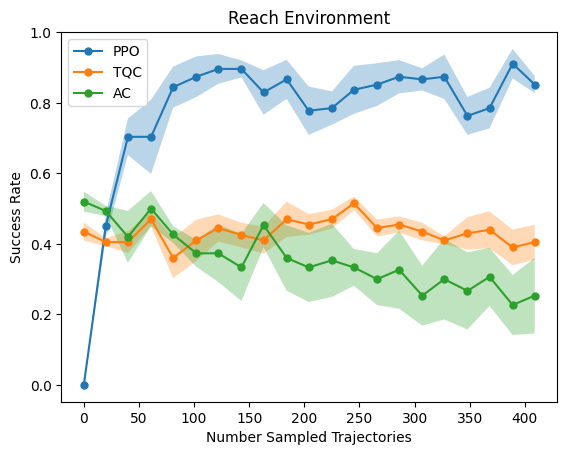

In [35]:
pp_AC_path = '/data/bing/hendrik/AC_var_2023-03-24/'

include_AC_pp = ['windowopenincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 'statsoptimized']
exclude_AC_pp = []

bl_path_PPO = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24'
include_PPO = ['PPO_GAIL_windowopen_lr_1e-05_demonstrations_4', 'learner']
exculde_PPO = []

bl_path_TQC = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-25'
include_TQC = ['TQC_GAIL_windowopen_lr_1e-07_demonstrations_4', 'learner']
exculde_TQC = []

make_plot(
    paths=[pp_AC_path, bl_path_PPO, bl_path_TQC], 
    includes=[include_AC_pp, include_PPO, include_TQC], 
    excludes=[exclude_AC_pp, exculde_PPO, exculde_TQC],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /data/bing/hendrik/AC_var_2023-03-23/: 3


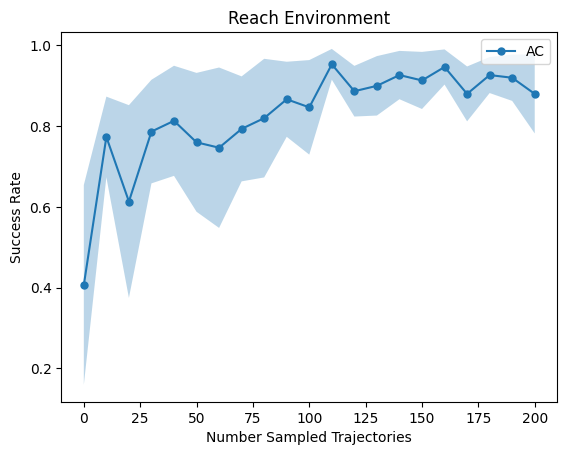

In [47]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-23/'

inculde_AC = ['drawerclosereinit tiny planner trainin eps: 200 opt mode: actor+plan demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25: 4


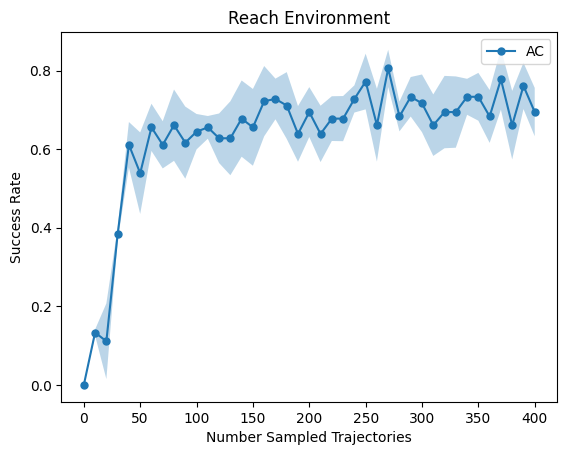

In [51]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['push 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Push Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25: 4


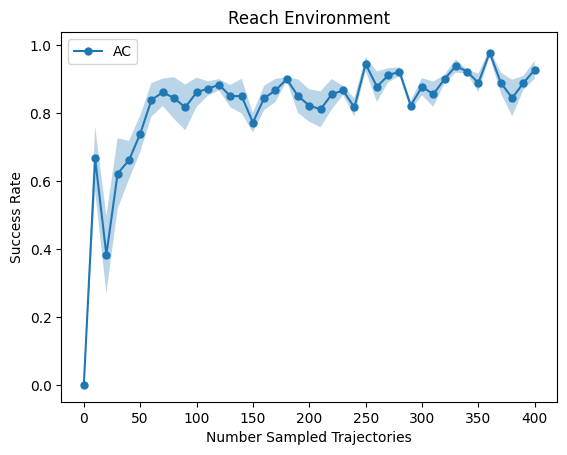

In [52]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['reach 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25: 4


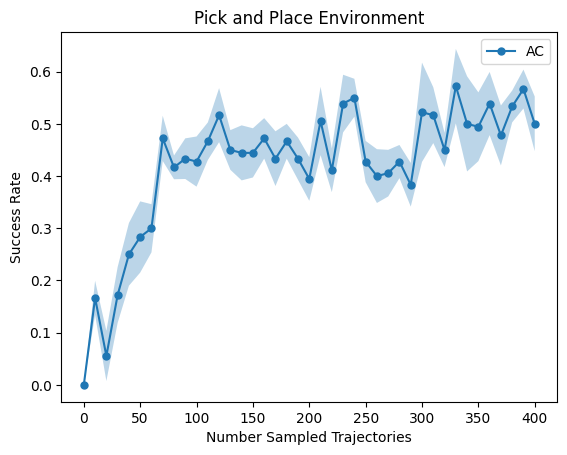

In [57]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-25'

inculde_AC = ['pickplace 1e-4 opr lr trainin eps: 400 opt mode: actor+plan demonstrations: 15, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 6000', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=True
    )

In [55]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-24'

inculde_AC = ['windowopenincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000 run', 'statsoptimized']
exclude_AC = []

make_plot(
    paths=[AC_path], 
    includes=[inculde_AC], 
    excludes=[exclude_AC],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )



for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-24: 0


KeyError: 'step'

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24: 5
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24: 2
for path: /data/bing/hendrik/AC_var_2023-03-24: 3
for path: /data/bing/hendrik/AC_var_2023-03-24: 3


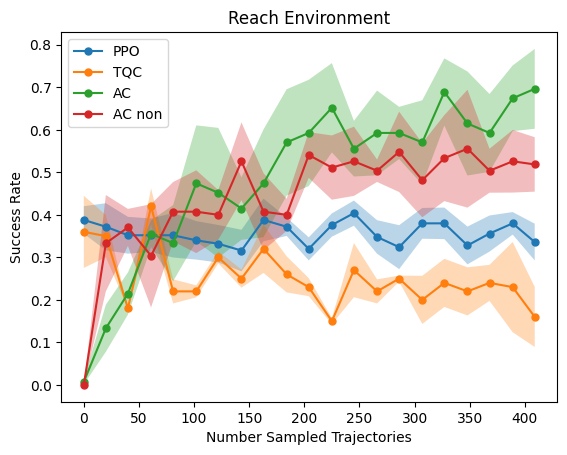

In [2]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24'

include_bl_PPO = ['learner', 'PPO_GAIL_reach_lr_1e-05_demonstrations_4']
exclude_bl_PPO = ['range(0, 3)']

include_bl_TQC = ['learner', 'TQC_GAIL_reach_lr_5e-07_demonstrations_4']
exclude_bl_TQC = ['id_2']

ac_path = '/data/bing/hendrik/AC_var_2023-03-24'

include_AC = ['reachincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 
              'statsoptimized']
exclude_AC = []

include_AC_non = ['reachincr incr tiny planner trainin eps: 400 opt mode: actor+plan demonstrations: 4, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 6000', 
              'stats']
exclude_AC_non = ['optimized']

make_plot(
    paths=[bl_path, bl_path, ac_path, ac_path], 
    includes=[include_bl_PPO, include_bl_TQC, include_AC, include_AC_non], 
    excludes=[exclude_bl_PPO, exclude_bl_TQC, exclude_AC, exclude_AC_non],
    names=['PPO', 'TQC', 'AC', 'AC non'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /data/bing/hendrik/AC_var_2023-03-21: 1
for path: /data/bing/hendrik/Baselines_Stats_GAIL_2023-03-21: 1
for path: /data/bing/hendrik/Baselines_Stats_GAIL_2023-03-21: 1


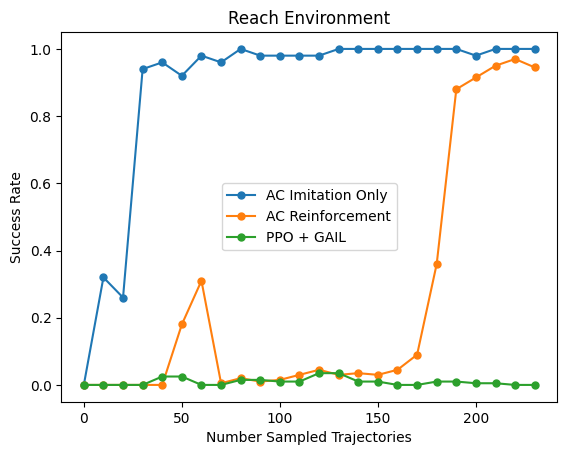

In [45]:
AC_path = '/data/bing/hendrik/AC_var_2023-03-21'
bl_path = '/data/bing/hendrik/Baselines_Stats_GAIL_2023-03-21'

include_ac_0 = ['stats', 'drawerclose tiny planner trainin eps: 1000 opt mode: actor demonstrations: 0, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 1000']
exclude_ac_0 = ['optimized']

include_TQC_0 = ['learner', 'TQC_drawerclose_lr_1e-06_demonstrations_0_n_samples_20000']
exclude_TQC_0 = []

include_PPO_0 = ['learner', 'PPO_drawerclose_lr_1e-05_demonstrations_0_n_samples_20000']
exclude_PPO_0 = []


make_plot(
    paths=[AC_path, bl_path, bl_path], 
    includes=[include_ac_0, include_TQC_0, include_PPO_0], 
    excludes=[exclude_ac_0, exclude_TQC_0, exclude_PPO_0],
    names=['AC Imitation Only', 'AC Reinforcement', 'PPO + GAIL', 'BC + RPPO', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=True
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22: 1
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20/: 1
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20/: 1


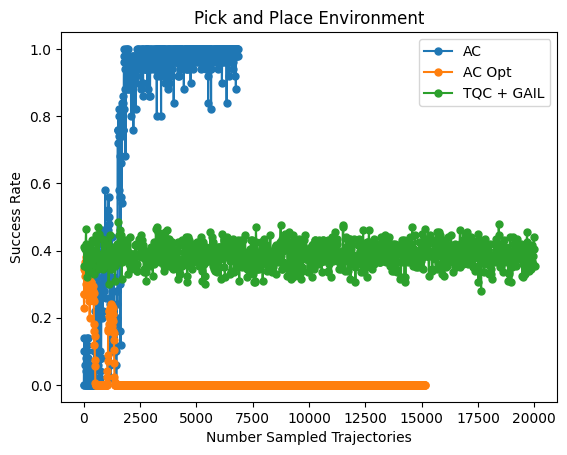

In [52]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-22'

bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20/'

include_bl_TQC = ['learner', 'TQC_reach_lr_1e-06_demonstrations_4_n_samples_20000_id_0']
exclude_bl_TQC = []

include_bl_PPO = ['learner', 'PPO_reach_lr_1e-05_demonstrations_4_n_samples_20000_id_0']
exclude_bl_PPO = []

include_ac = ['reach tiny planner trainin eps: 20000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 2000', 'stats']
exclude_ac = ['optimize', 'id: 1']

include_ac_opt = ['reach tiny planner trainin eps: 20000 opt mode: actor+plan demonstrations: 1, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.1, val_every: 2000', 'statsoptimize']
exclude_ac_opt = ['id: 1']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, bl_path, bl_path], 
    includes=[include_ac, include_bl_TQC, include_bl_PPO], 
    excludes=[exclude_ac, exclude_bl_TQC, exclude_bl_PPO],
    names=['AC', 'AC Opt', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [1]:
import torch as th


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
from active_critic.utils.gym_utils import make_policy_dict
pd = make_policy_dict()

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [37]:
for key in pd:
    print(key)

assembly
basketball
binpicking
boxclose
buttonpresstopdown
buttonpresstopdownwall
buttonpress
buttonpresswall
coffeebutton
coffeepull
coffeepush
dialturn
disassemble
doorclose
doorlock
dooropen
doorunlock
handinsert
drawerclose
draweropen
faucetopen
faucetclose
hammer
handlepressside
handlepress
handlepullside
handlepull
leverpull
pickplacewall
pickoutofhole
reach
pushback
push
pickplace
plateslide
plateslideside
plateslideback
plateslidebackside
pegunplugside
soccer
stickpush
stickpull
pushwall
reachwall
shelfplace
sweepinto
sweep
windowopen
windowclose


In [ ]:
PPO_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-20'

include_PPO = ['PPO_reach_lr_1e-05_demonstrations_4_n_samples_20000', 'learner']
exclude_PPO = ['id_1']


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[PPO_path], 
    includes=[include_PPO], 
    excludes=[exclude_PPO],
    names=['PPO', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Reach Environment',
    save_path = None,
    plot_closest=False
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24: 1


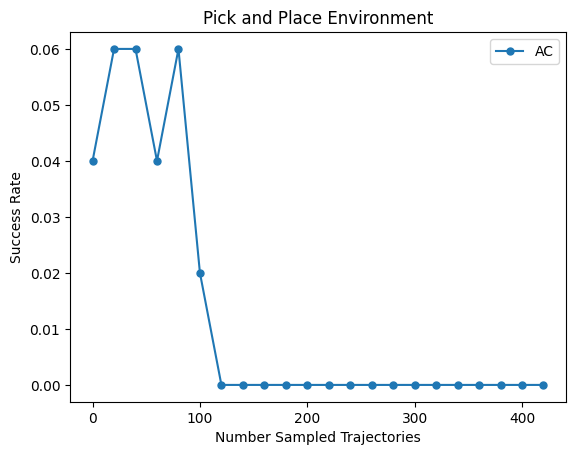

In [42]:
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-03-24'

include = ['TQC_GAIL_push_lr_5e-07_demonstrations_4_id_range(0, 3)', 'learner']
exclude = []

make_plot(
    paths=[bl_path], 
    includes=[include], 
    excludes=[exclude],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL', 'RPPO + BC'],
    plot_name='Pick and Place Environment',
    save_path = None,
    plot_closest=False
    )

In [ ]:
AC_Path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-03-01/'

include_bl = ['pickplace demonstrations: 14, im_ph:False, training_episodes: 10, min critic: 5e-05, wd: 0.01, val_every: 2000', 'stats']
exclude_bl = ['20000']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_Path], 
    includes=[include_bl, include_ac_opt, include_bl], 
    excludes=[exclude_bl, exclude_ac_opt, exclude_bl],
    names=['AC', 'AC Imitation', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'


include_ac = ['push', '20','True', 'stats', '2000']
exclude_ac = ['optimize']

include_ac2 = ['push', '20','False', 'stats', '5000']
exclude_ac2 = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path], 
    includes=[include_ac, include_ac2, include_bl], 
    excludes=[exclude_ac, exclude_ac2, []],
    names=['AC Imitation', 'AC Reinfocement', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
from active_critic.analyze_stats.push_TQC_PPO_GAIL_5000_10000 import run_exp
run_exp()

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22_val_1000'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '20','True', 'stats']
exclude_ac = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac1 = ['push', '15','False', 'stats']
exclude_ac1 = ['optimize']

include_ac2 = ['push', '15','True', 'stats']
exclude_ac2 = ['optimize']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_ac1, include_ac2], 
    excludes=[exclude_ac1, []],
    names=['AC', 'AC Imitation'],
    plot_name='Push Environment',
    save_path = None
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-21'

include_ac = ['pickplace demonstrations: 6, im_ph:False', 'stats']
exclude_ac = ['optimize']

include_bl14 = ['demonstrations_14', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl10 = ['demonstrations_10', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl6 = ['demonstrations_6', 'learner', 'push', 'TQC', 'id_0']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[bl_path, bl_path, bl_path], 
    includes=[include_bl14, include_bl10, include_bl6], 
    excludes=[exclude_bl, exclude_bl, exclude_bl],
    names=['14', '10', '6'],
    plot_name='Push Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/AC/'
PPOGail = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/PPO GAIL'
TQCPath = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/TQC GAIL'

include_ac = ['stats']
exclude_ac = ['optimize']

include_PPOGail = ['learner']
exclude_bl = []

include_TQC = ['learner']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, PPOGail, TQCPath], 
    includes=[include_ac, include_PPOGail, include_TQC], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = None,
    common_steps=True
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

include_ac = ['stats', 'window', '6']
exclude_ac = ['optimize']


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path], 
    includes=[include_ac], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None
    )